Mounted at /content/drive


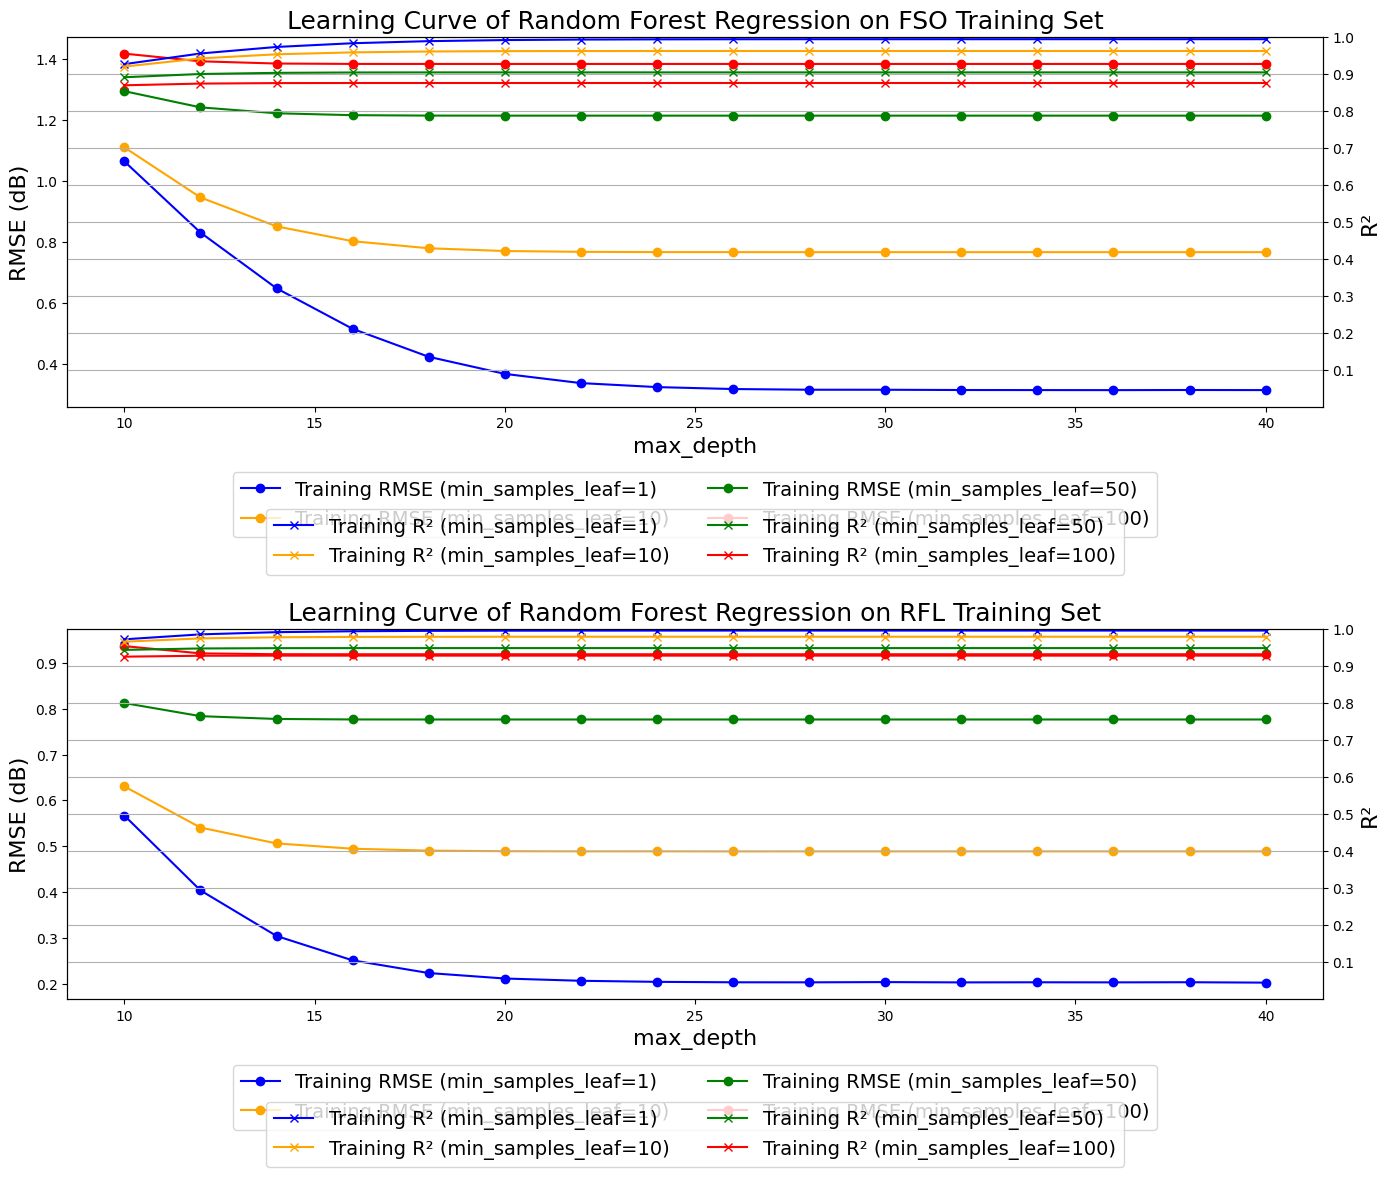

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train_fso, X_temp_fso, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val_fso, X_test_fso, y_val_fso, y_test_fso = train_test_split(X_temp_fso, y_temp_fso, test_size=0.5, random_state=42)

X_train_rfl, X_temp_rfl, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val_rfl, X_test_rfl, y_val_rfl, y_test_rfl = train_test_split(X_temp_rfl, y_temp_rfl, test_size=0.5, random_state=42)

# Function to plot learning curves
def plot_learning_curves(X_train, y_train, title, ax):
    max_depth_values = range(10, 41, 2)
    min_samples_leaf_values = [1, 10, 50, 100]
    colors = ['blue', 'orange', 'green', 'red']

    ax_r2 = ax.twinx()

    for min_samples_leaf, color in zip(min_samples_leaf_values, colors):
        train_rmse = []
        train_r2 = []

        for max_depth in max_depth_values:
            model = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=100)

            # Compute RMSE and R² on training set
            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            train_rmse.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
            train_r2.append(r2_score(y_train, train_predictions))

        # Plot RMSE on left y-axis
        ax.plot(max_depth_values, train_rmse, 'o-', color=color, label=f"Training RMSE (min_samples_leaf={min_samples_leaf})")

        # Plot R² on right y-axis
        ax_r2.plot(max_depth_values, train_r2, 'x-', color=color, label=f"Training R² (min_samples_leaf={min_samples_leaf})")

    ax.set_xlabel('max_depth', fontsize=16)
    ax.set_ylabel('RMSE (dB)', fontsize=16)
    ax.set_title(title, fontsize=18)

    # Move the RMSE legend below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=14)

    ax_r2.set_ylabel('R²', fontsize=16)
    ax_r2.set_ylim([0, 1])
    ax_r2.set_yticks(np.arange(0.1, 1.1, 0.1))  # Evenly divided y-axis for R²

    # Move the R² legend below the plot
    ax_r2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=14)
    ax_r2.grid(True)  # Optionally add grid for better readability
    ax_r2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Only show grid values on y-axis


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

plot_learning_curves(X_train_fso, y_train_fso, 'Learning Curve of Random Forest Regression on FSO Training Set', axs[0])
plot_learning_curves(X_train_rfl, y_train_rfl, 'Learning Curve of Random Forest Regression on RFL Training Set', axs[1])

plt.tight_layout()
plt.show()

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': range(10, 41, 2),
    'min_samples_leaf': [1, 10, 50, 100],
    'min_samples_split': [2, 11, 51, 101],
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error']
}

# Function to perform RandomizedSearchCV
def perform_randomized_search(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

# Perform RandomizedSearchCV for FSO and RFL
best_params_fso, best_score_fso = perform_randomized_search(X_train_fso, y_train_fso)
best_params_rfl, best_score_rfl = perform_randomized_search(X_train_rfl, y_train_rfl)





Mounted at /content/drive


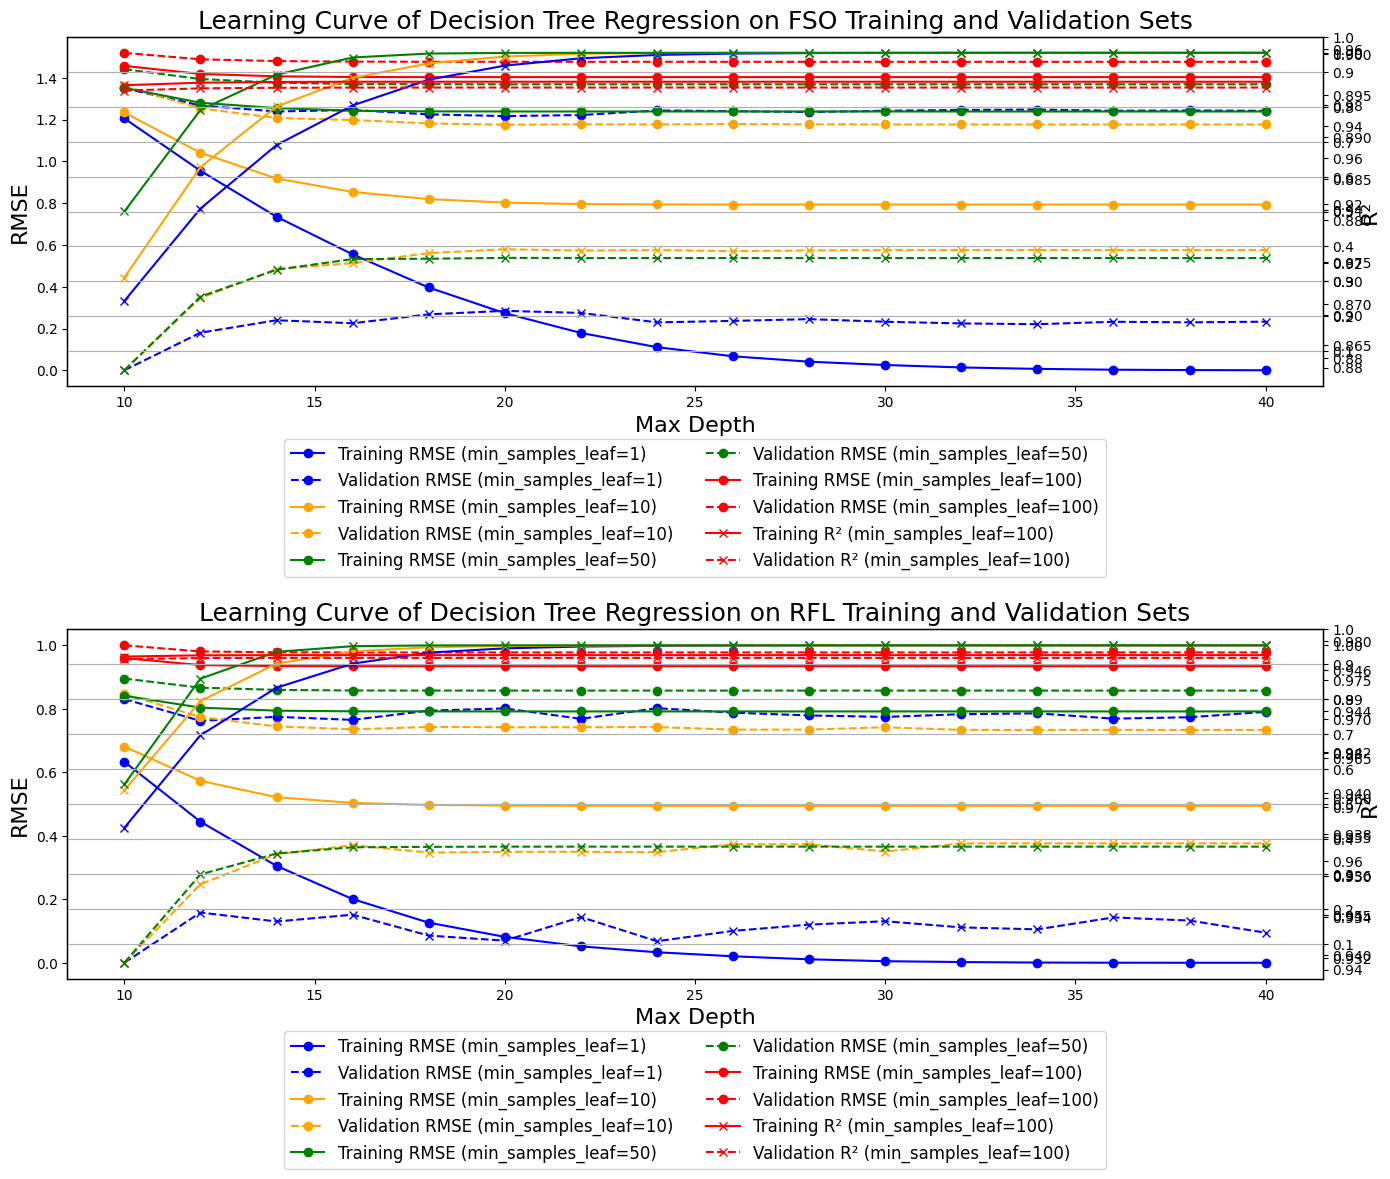

Best parameters for FSO Attenuation: {'max_depth': 22, 'min_samples_leaf': 10}
Best parameters for RFL Attenuation: {'max_depth': 22, 'min_samples_leaf': 10}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train_fso, X_temp_fso, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val_fso, X_test_fso, y_val_fso, y_test_fso = train_test_split(X_temp_fso, y_temp_fso, test_size=0.5, random_state=42)

X_train_rfl, X_temp_rfl, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val_rfl, X_test_rfl, y_val_rfl, y_test_rfl = train_test_split(X_temp_rfl, y_temp_rfl, test_size=0.5, random_state=42)

# Function to plot learning curves
def plot_learning_curves(X_train, y_train, X_val, y_val, title, ax):
    max_depth_values = range(10, 41, 2)  # Changed to start from 10 and go up to 40 in steps of 2
    min_samples_leaf_values = [1, 10, 50, 100]
    colors = ['blue', 'orange', 'green', 'red']

    for min_samples_leaf, color in zip(min_samples_leaf_values, colors):
        train_rmse = []
        train_r2 = []
        val_rmse = []
        val_r2 = []

        for max_depth in max_depth_values:
            model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

            # Compute RMSE and R² on training set
            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            train_rmse.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
            train_r2.append(r2_score(y_train, train_predictions))

            # Compute RMSE and R² on validation set
            val_predictions = model.predict(X_val)
            val_rmse.append(np.sqrt(mean_squared_error(y_val, val_predictions)))
            val_r2.append(r2_score(y_val, val_predictions))

        # Plot RMSE on left y-axis
        ax.plot(max_depth_values, train_rmse, 'o-', color=color, label=f"Training RMSE (min_samples_leaf={min_samples_leaf})")
        ax.plot(max_depth_values, val_rmse, 'o--', color=color, label=f"Validation RMSE (min_samples_leaf={min_samples_leaf})")

        # Plot R² on right y-axis
        ax_r2 = ax.twinx()
        ax_r2.plot(max_depth_values, train_r2, 'x-', color=color, label=f"Training R² (min_samples_leaf={min_samples_leaf})")
        ax_r2.plot(max_depth_values, val_r2, 'x--', color=color, label=f"Validation R² (min_samples_leaf={min_samples_leaf})")

    ax.set_xlabel('Max Depth', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_title(title, fontsize=18)

    # Combined legend for both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_r2.get_legend_handles_labels()
    all_lines = lines + lines2
    all_labels = labels + labels2

    # Place the legend below the plot
    ax.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12, borderaxespad=0)

    ax_r2.set_ylabel('R²', fontsize=16)
    ax_r2.set_ylim([0, 1])
    ax_r2.set_yticks(np.arange(0.1, 1.1, 0.1))  # Evenly divided y-axis for R²
    ax_r2.grid(True)  # Optionally add grid for better readability
    ax_r2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Only show grid values on y-axis

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

plot_learning_curves(X_train_fso, y_train_fso, X_val_fso, y_val_fso, 'Learning Curve of Decision Tree Regression on FSO Training and Validation Sets', axs[0])
plot_learning_curves(X_train_rfl, y_train_rfl, X_val_rfl, y_val_rfl, 'Learning Curve of Decision Tree Regression on RFL Training and Validation Sets', axs[1])

plt.tight_layout()
plt.show()

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': range(10, 41, 2),
    'min_samples_leaf': [1, 10, 50, 100]
}

# Function to perform GridSearchCV
def perform_grid_search(X_train, y_train):
    model = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

# Perform GridSearchCV for FSO and RFL
best_params_fso, best_score_fso = perform_grid_search(X_train_fso, y_train_fso)
best_params_rfl, best_score_rfl = perform_grid_search(X_train_rfl, y_train_rfl)

print("Best parameters for FSO Attenuation:", best_params_fso)
print("Best parameters for RFL Attenuation:", best_params_rfl)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


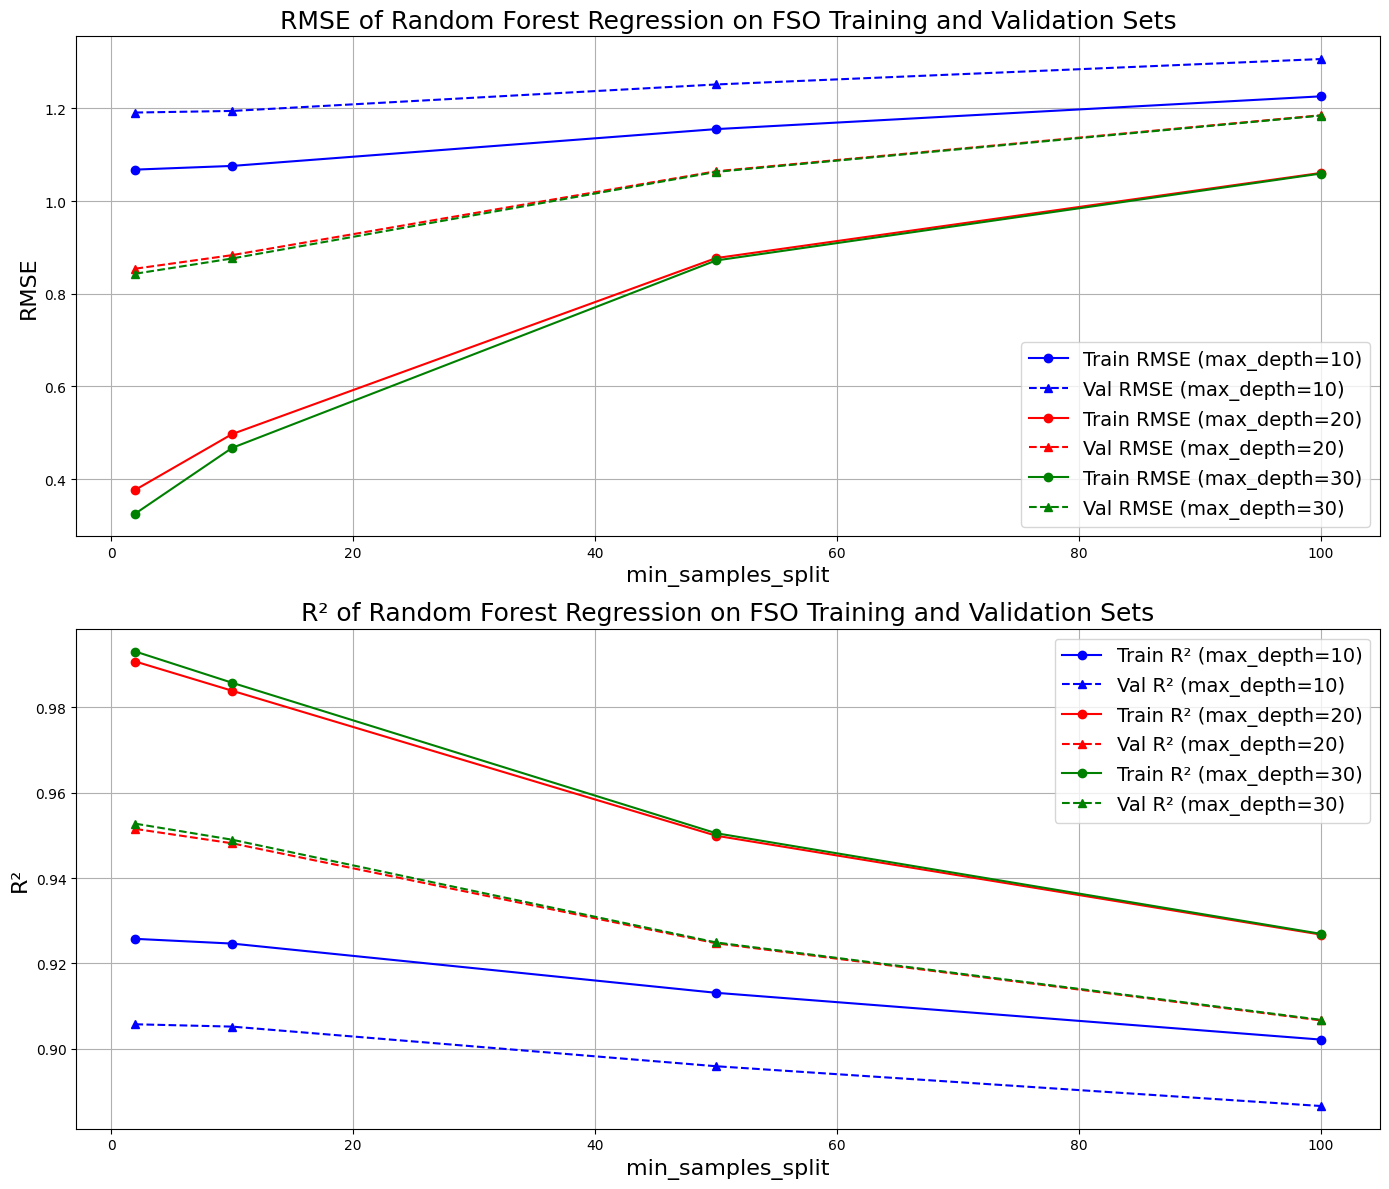

Best min_samples_split for RMSE:
Max Depth: 10, Best min_samples_split: 2, Val RMSE: 1.190884437546105
Max Depth: 20, Best min_samples_split: 2, Val RMSE: 0.8540358270802558
Max Depth: 30, Best min_samples_split: 2, Val RMSE: 0.8431872308394065

Best min_samples_split for R²:
Max Depth: 10, Best min_samples_split: None, Val R²: inf
Max Depth: 20, Best min_samples_split: None, Val R²: inf
Max Depth: 30, Best min_samples_split: None, Val R²: inf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train_fso, X_temp_fso, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val_fso, X_test_fso, y_val_fso, y_test_fso = train_test_split(X_temp_fso, y_temp_fso, test_size=0.5, random_state=42)

X_train_rfl, X_temp_rfl, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val_rfl, X_test_rfl, y_val_rfl, y_test_rfl = train_test_split(X_temp_rfl, y_temp_rfl, test_size=0.5, random_state=42)

# Function to plot RMSE and R² and print the best min_samples_split
def plot_metrics_and_find_best_min_samples_split(X_train, y_train, X_val, y_val, metric_name, ax, legend_loc):
    min_samples_split_values = [2, 10, 50, 100]
    max_depth_values = [10, 20, 30]
    colors = ['blue', 'red', 'green']
    markers = ['o', '^']

    best_min_samples_split = {max_depth: {'min_samples_split': None, 'val_metric': float('inf')} for max_depth in max_depth_values}

    for max_depth, color in zip(max_depth_values, colors):
        train_metric = []
        val_metric = []

        for min_samples_split in min_samples_split_values:
            model = RandomForestRegressor(max_depth=max_depth, n_estimators=50, min_samples_split=min_samples_split, random_state=42)

            # Fit model and predict
            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            val_predictions = model.predict(X_val)

            if metric_name == 'RMSE':
                train_metric_value = np.sqrt(mean_squared_error(y_train, train_predictions))
                val_metric_value = np.sqrt(mean_squared_error(y_val, val_predictions))
            elif metric_name == 'R²':
                train_metric_value = r2_score(y_train, train_predictions)
                val_metric_value = r2_score(y_val, val_predictions)

            train_metric.append(train_metric_value)
            val_metric.append(val_metric_value)

            # Update best min_samples_split
            if metric_name == 'RMSE' and val_metric_value < best_min_samples_split[max_depth]['val_metric']:
                best_min_samples_split[max_depth]['min_samples_split'] = min_samples_split
                best_min_samples_split[max_depth]['val_metric'] = val_metric_value

        # Plot train metric
        ax.plot(min_samples_split_values, train_metric, marker=markers[0], color=color, label=f'Train {metric_name} (max_depth={max_depth})')
        # Plot val metric
        ax.plot(min_samples_split_values, val_metric, marker=markers[1], linestyle='dashed', color=color, label=f'Val {metric_name} (max_depth={max_depth})')

    ax.set_xlabel('min_samples_split', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_title(f'{metric_name} of Random Forest Regression on FSO Training and Validation Sets', fontsize=18)
    ax.legend(loc=legend_loc, fontsize=14)
    ax.grid(True)

    return best_min_samples_split

# Plotting RMSE and R²
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

best_min_samples_split_rmse = plot_metrics_and_find_best_min_samples_split(X_train_fso, y_train_fso, X_val_fso, y_val_fso, 'RMSE', axs[0], legend_loc='lower right')
best_min_samples_split_r2 = plot_metrics_and_find_best_min_samples_split(X_train_fso, y_train_fso, X_val_fso, y_val_fso, 'R²', axs[1], legend_loc='upper right')

plt.tight_layout()
plt.show()


Mounted at /content/drive


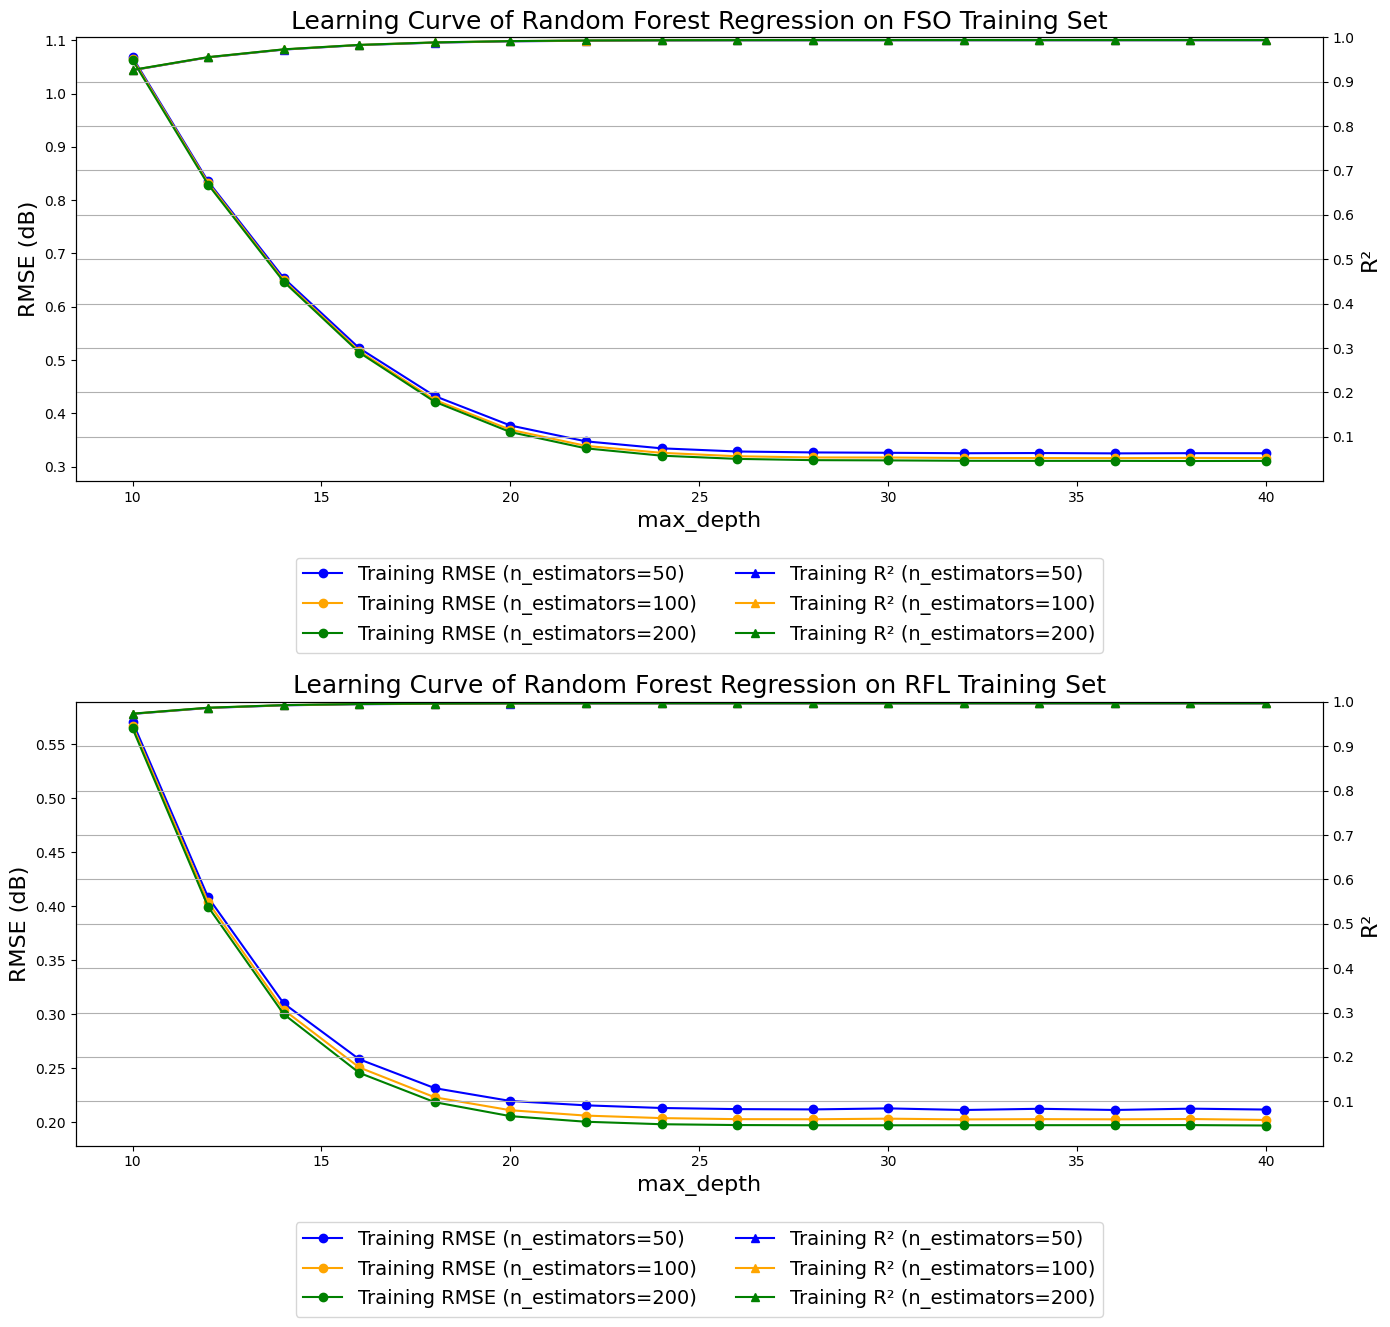

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att":"FSO_Att",
        "RFL_Att":"RFL_Att",
        "AbsoluteHumidity":"AH",
        "AbsoluteHumidityMax":"AH_Max",
        "AbsoluteHumidityMin":"AH_Min",
        "Distance":"Dist",
        "Frequency":"Freq",
        "Particulate":"Part",
        "ParticulateMax":"Part_Max",
        "ParticulateMin":"Part_Min",
        "RainIntensity":"RainInt",
        "RainIntensityMax":"RainInt_Max",
        "RainIntensityMin":"RainInt_Min",
        "RelativeHumidity":"RH",
        "SYNOPCode":"SYNOPCode",
        "Temperature":"Temp",
        "TemperatureDifference":"TDiff",
        "TemperatureMax":"Temp_Max",
        "TemperatureMin":"Temp_Min",
        "Time":"Time",
        "Visibility":"Visi",
        "VisibilityMax":"Visi_Max",
        "VisibilityMin":"Visi_Min",
        "WindDirection":"WD",
        "WindSpeed":"WS",
        "WindSpeedMax":"WS_Max",
        "WindSpeedMin":"WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Load and preprocess the data
data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train_fso, X_temp_fso, y_train_fso, y_temp_fso = train_test_split(X, y_fso, test_size=0.3, random_state=42)
X_val_fso, X_test_fso, y_val_fso, y_test_fso = train_test_split(X_temp_fso, y_temp_fso, test_size=0.5, random_state=42)

X_train_rfl, X_temp_rfl, y_train_rfl, y_temp_rfl = train_test_split(X, y_rfl, test_size=0.3, random_state=42)
X_val_rfl, X_test_rfl, y_val_rfl, y_test_rfl = train_test_split(X_temp_rfl, y_temp_rfl, test_size=0.5, random_state=42)

# Function to plot learning curves
def plot_learning_curves(X_train, y_train, title, ax):
    n_estimators_values = [50, 100, 200]
    max_depth_values = range(10, 41, 2)
    colors = ['blue', 'orange', 'green']

    ax_r2 = ax.twinx()

    for n_estimators, color in zip(n_estimators_values, colors):
        train_rmse = []
        train_r2 = []

        for max_depth in max_depth_values:
            model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)

            # Compute RMSE and R² on training set
            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            train_rmse.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
            train_r2.append(r2_score(y_train, train_predictions))

        # Plot RMSE on left y-axis
        ax.plot(max_depth_values, train_rmse, 'o-', color=color, label=f"Training RMSE (n_estimators={n_estimators})")

        # Plot R² on right y-axis
        ax_r2.plot(max_depth_values, train_r2, '^-', color=color, label=f"Training R² (n_estimators={n_estimators})")

    ax.set_xlabel('max_depth', fontsize=16)
    ax.set_ylabel('RMSE (dB)', fontsize=16)
    ax.set_title(title, fontsize=18)

    ax_r2.set_ylabel('R²', fontsize=16)
    ax_r2.set_ylim([0, 1])
    ax_r2.set_yticks(np.arange(0.1, 1.1, 0.1))  # Evenly divided y-axis for R²
    ax_r2.grid(True)  # Optionally add grid for better readability
    ax_r2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # Format R² ticks

    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines_r2, labels_r2 = ax_r2.get_legend_handles_labels()
    ax.legend().remove()  # Remove legends from within the plot
    ax_r2.legend().remove()

    ax.legend(lines + lines_r2, labels + labels_r2, loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=14, ncol=2)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

plot_learning_curves(X_train_fso, y_train_fso, 'Learning Curve of Random Forest Regression on FSO Training Set', axs[0])
plot_learning_curves(X_train_rfl, y_train_rfl, 'Learning Curve of Random Forest Regression on RFL Training Set', axs[1])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for legends below plots
plt.show()


# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': range(10, 41, 2),
    'n_estimators': [50, 100, 200]
}

# Function to perform GridSearchCV
def perform_grid_search(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

# Perform GridSearchCV for FSO and RFL
best_params_fso, best_score_fso = perform_grid_search(X_train_fso, y_train_fso)
best_params_rfl, best_score_rfl = perform_grid_search(X_train_rfl, y_train_rfl)
